<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/067.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [55]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [56]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train_all_df_060.csv', index_col=0)

# train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test_all_df_060.csv', index_col=0)

In [57]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [58]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [59]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


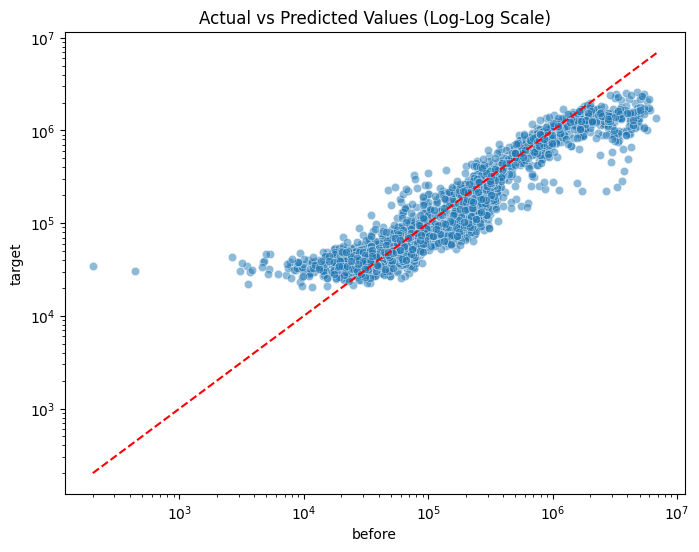

In [60]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

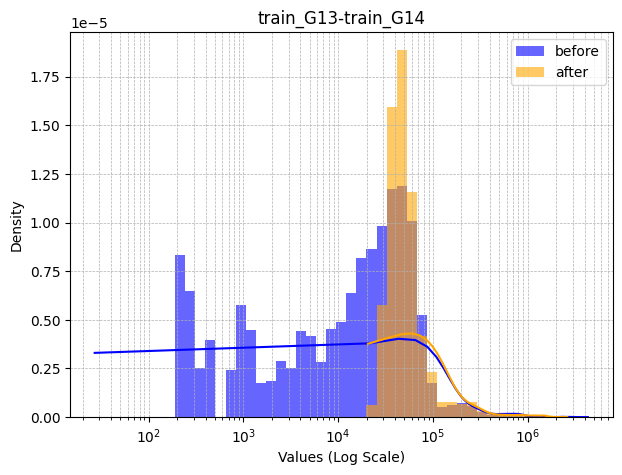

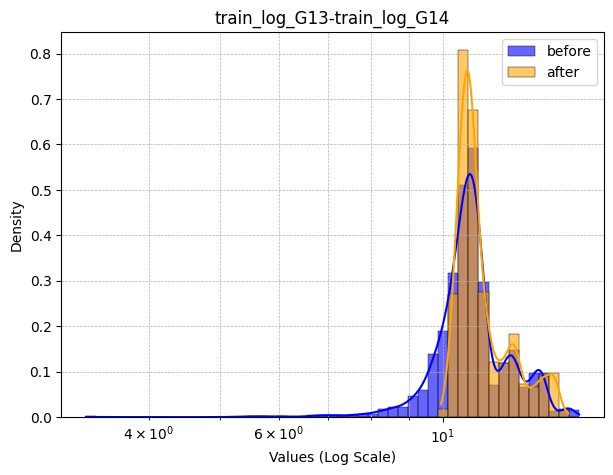

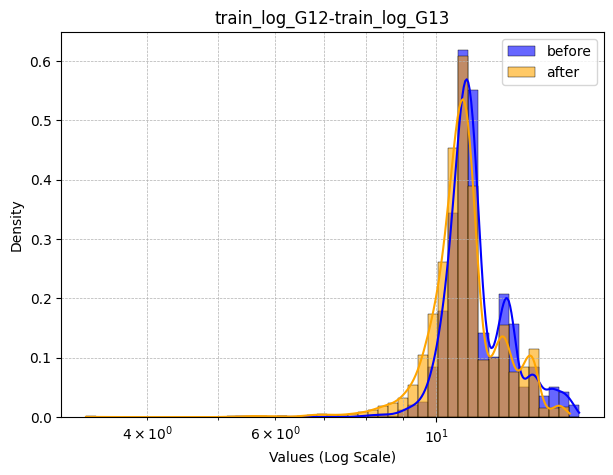

In [61]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons.1"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [62]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.rename(columns={'test_preds': 'oof_predictions'}, inplace=True)

Index(['TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'test_preds'],
      dtype='object')


In [ ]:
test_df

In [63]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547","42,214"
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","58,500"
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121","99,409"
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450","51,623"
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060","50,638"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079","537,502"
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312","99,339"
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940","137,959"
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619","261,207"


In [64]:
diff = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_df['oof_predictions'])

# 2. 条件を満たす行のマスクを作成
mask = diff > 1
# 3. 除外する行の数をカウント
exclude_num = mask.sum()
# 4. 条件を満たさない行だけを保持
train_df = train_df[~mask]
print(f"除外された行の数: {exclude_num}")

除外された行の数: 0


In [65]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547","42,214"
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","58,500"
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121","99,409"
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450","51,623"
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060","50,638"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079","537,502"
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312","99,339"
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940","137,959"
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619","261,207"


In [66]:
len(train_df), len(train_all_df), len(test_df)

(4655, 7163, 2508)

In [67]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions'])
train_all_df['diff'] = diff
train_df = train_all_df[:4655]
test_df = train_all_df[4655:]

In [68]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547","42,214",0
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","58,500",-0
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121","99,409",0
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450","51,623",0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060","50,638",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079","537,502",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312","99,339",-0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940","137,959",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619","261,207",-0


In [69]:
train_all_df["oof_predictions"].fillna(train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"], inplace=True)
train_all_df["diff"].fillna(0, inplace=True)

In [70]:
train_all_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)
train_df_GHG14 = train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
train_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [71]:
test_df["oof_predictions"] = test_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
test_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [72]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            rmsle = np.sqrt(mean_squared_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = test_predictions
    final_train_predictions = train_eval_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions, final_train_predictions

In [73]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547",0
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121",0
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450",0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,"19,192","26,927",20,"77,141","48,631","47,793","26,264",31,-93,"8,851","-4,910","7,736",1,-0,0,15,0,"46,740",0
4651,NaN,NaN,92,"82,220","64,716","230,047","560,694",34,-118,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"170,355",-0
4652,"25,344","25,052",80,"28,607","19,290","31,161","41,109",45,-90,"2,857","1,088",-292,0,0,-0,8,0,"31,492",0
4653,"15,031","15,797",98,"88,532","72,952","58,935","53,984",38,-98,"8,122","-10,314",766,0,-0,0,8,0,"66,290",-0


In [74]:
train = train_df.iloc[:, :-1].values
train_target = train_df.iloc[:, -1].values
train_all = train_all_df.iloc[:, :-1].values
train_all_target = train_all_df.iloc[:, -1].values
test = test_df.iloc[:, :-1].values

In [75]:
oof_predictions,test_preds, train_preds  = get_models_trained(train_all, test, train_all_target, 30, train)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.021988920978924558
Fold 1 RMSLE for model2 = 0.015450859517853306
Fold 1 RMSLE for model3 = 0.02343101777384949
Fold 1 RMSLE for model4 = 0.018135718453352764
Fold 1 RMSLE for ('model1', 'model2') = 0.01840005933492665
Fold 1 RMSLE for ('model1', 'model3') = 0.02262182623831814
Fold 1 RMSLE for ('model1', 'model4') = 0.019848037298783573
Fold 1 RMSLE for ('model2', 'model3') = 0.019001068567774615
Fold 1 RMSLE for ('model2', 'model4') = 0.016684044221293496
Fold 1 RMSLE for ('model3', 'model4') = 0.020441348843128832
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.019928051006074848
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.018234004891368647
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.020903832385752788
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.018596119026737117
Fold 1 RMSLE for all models ensemble = 0.019374088236233065
Fold 1 best combination: model2 with RMSLE = 0.015450859517853306
---------------

Starti

In [79]:
test_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"45,108",0
1,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"293,984",-0
2,"26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,227",0
3,"43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"29,464",-0
4,"40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"48,383",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"537,502",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,339",-0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"137,959",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"261,207",-0


In [80]:
train_df["oof_predictions"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)
train_df["GHG_Direct_Emissions_14_in_metric_tons.1"] = train_df_GHG14
train_df.drop(["diff"], axis=1, inplace=True)



In [85]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"42,892","42,214"
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"57,720","58,500"
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"97,385","99,409"
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"52,143","51,623"
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,220","50,638"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,"19,192","26,927",20,"77,141","48,631","47,793","26,264",31,-93,"8,851","-4,910","7,736",1,-0,0,15,0,"52,280","49,222"
4651,NaN,NaN,92,"82,220","64,716","230,047","560,694",34,-118,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"168,315","169,634"
4652,"25,344","25,052",80,"28,607","19,290","31,161","41,109",45,-90,"2,857","1,088",-292,0,0,-0,8,0,"31,986","31,716"
4653,"15,031","15,797",98,"88,532","72,952","58,935","53,984",38,-98,"8,122","-10,314",766,0,-0,0,8,0,"64,828","65,663"


In [84]:

test_df["test_preds"] = np.expm1(np.log1p(test_df["oof_predictions"])+test_preds)
# test_df.drop(["diff"], axis=1, inplace=True)
# test_df.drop(["GHG_Direct_Emissions_14_in_metric_tons.1"], axis=1, inplace=True)
test_df


,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,test_preds
0,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"45,108","45,533"
1,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"293,984","293,456"
2,"26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,227","41,167"
3,"43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"29,464","28,483"
4,"40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"48,383","48,696"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"537,502","549,521"
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,339","98,313"
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"137,959","140,770"
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"261,207","259,066"


In [86]:
train_df.to_csv("train_all_df_067.csv", index=False)
test_df.to_csv("test_all_df_067.csv", index=False)